In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import tqdm
import geopandas as gpd


In [5]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
neares_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)


(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

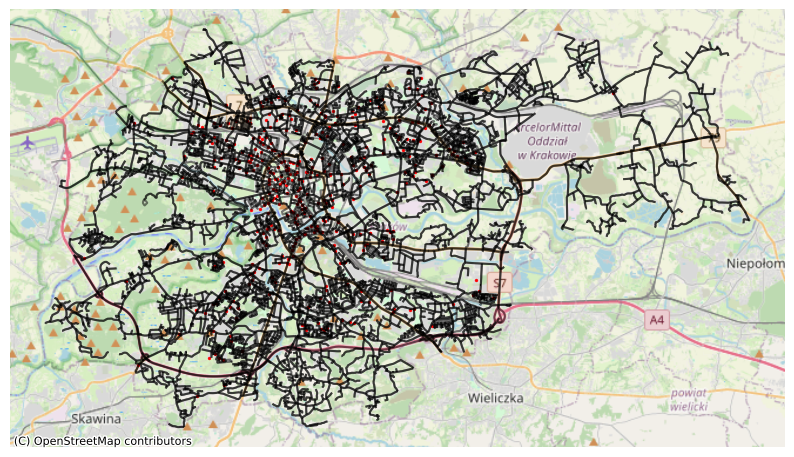

In [6]:
#plot map of Krakow
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.9, markersize=2)
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

Text(0, 0.5, 'Liczba sklepów')

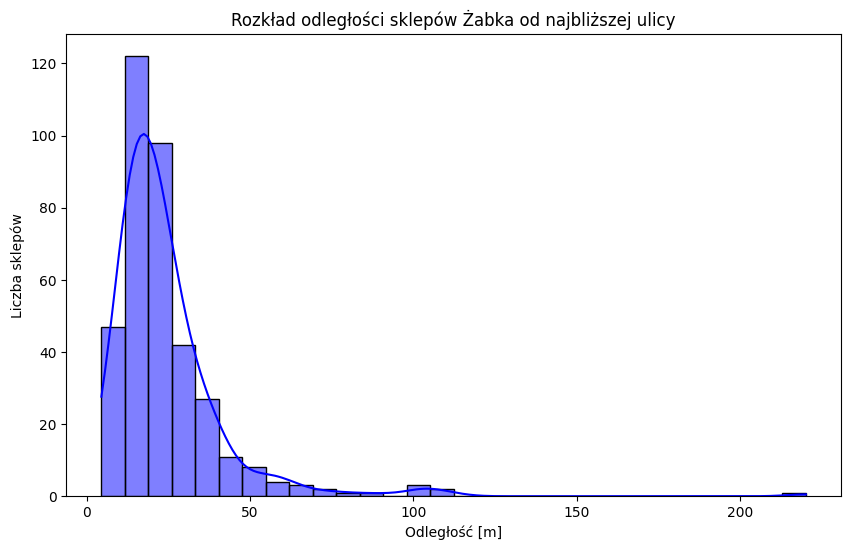

In [7]:
# histogram odległości sklepów Żabka od najbliższej ulicy
plt.figure(figsize=(10, 6))
sns.histplot(nearest_gdf['distance'], bins=30, color='blue', kde=True)
plt.title('Rozkład odległości sklepów Żabka od najbliższej ulicy')
plt.xlabel('Odległość [m]')
plt.ylabel('Liczba sklepów')


Widzimy tutaj, że niektóre odległości również są całkiem spore, jest tak ze względu na niekompletne dane ulic.


Możemy spróbować założyć dla przykładu, że faktyczny dystans do żabki od ulicy głownej to 2*dystans w linii prostej i uwzględnić te wartości przy tworzeniu macierzy odległości 

In [10]:
#simplify streets_gdf to get only geometry and length
streets_gdf.reset_index(inplace=True)
streets_gdf = streets_gdf[['geometry', 'length']]
streets_gdf.head()


,geometry,length
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",528.224
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",22.204
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",114.082
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",115.718
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",32.238


In [11]:
#how many points are in linestring of street
def count_points_in_line(row):
    return len(row['geometry'].coords)

streets_gdf['points_count'] = streets_gdf.apply(count_points_in_line, axis=1)
streets_gdf.head()

,geometry,length,points_count
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",528.224,6
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",22.204,4
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",114.082,8
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",115.718,4
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",32.238,3


In [12]:
#calculate length of street in meters using geopy
from geopy.distance import geodesic
from shapely.geometry import Point

def calculate_length(row):
    length = 0
    for i in range(1, len(row['geometry'].coords)):
        length += geodesic(row['geometry'].coords[i-1][::-1], row['geometry'].coords[i][::-1]).m
    return length

streets_gdf['length(estimated)'] = streets_gdf.apply(calculate_length, axis=1)
streets_gdf['length_per_point(estimated)'] = streets_gdf['length(estimated)'] / streets_gdf['points_count']
#drop length column
streets_gdf.drop(columns=['length'], inplace=True)
streets_gdf.head()

,geometry,points_count,length(estimated),length_per_point(estimated)
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",6,529.253296,88.208883
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",4,22.237751,5.559438
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",8,114.252000,14.281500
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",4,115.944461,28.986115
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",3,32.286032,10.762011


In [13]:
import networkx as nx

# Tworzenie grafu ulic
G = nx.Graph()
for idx, row in streets_gdf.iterrows():
    distance_per_point = row['length_per_point(estimated)']
    coords = list(row['geometry'].coords)
    for i in range(len(coords) - 1):
        G.add_edge(coords[i], coords[i + 1], weight=distance_per_point)
        


In [14]:
#Jak wielki jest graf?
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())


Number of nodes: 80766
Number of edges: 83714


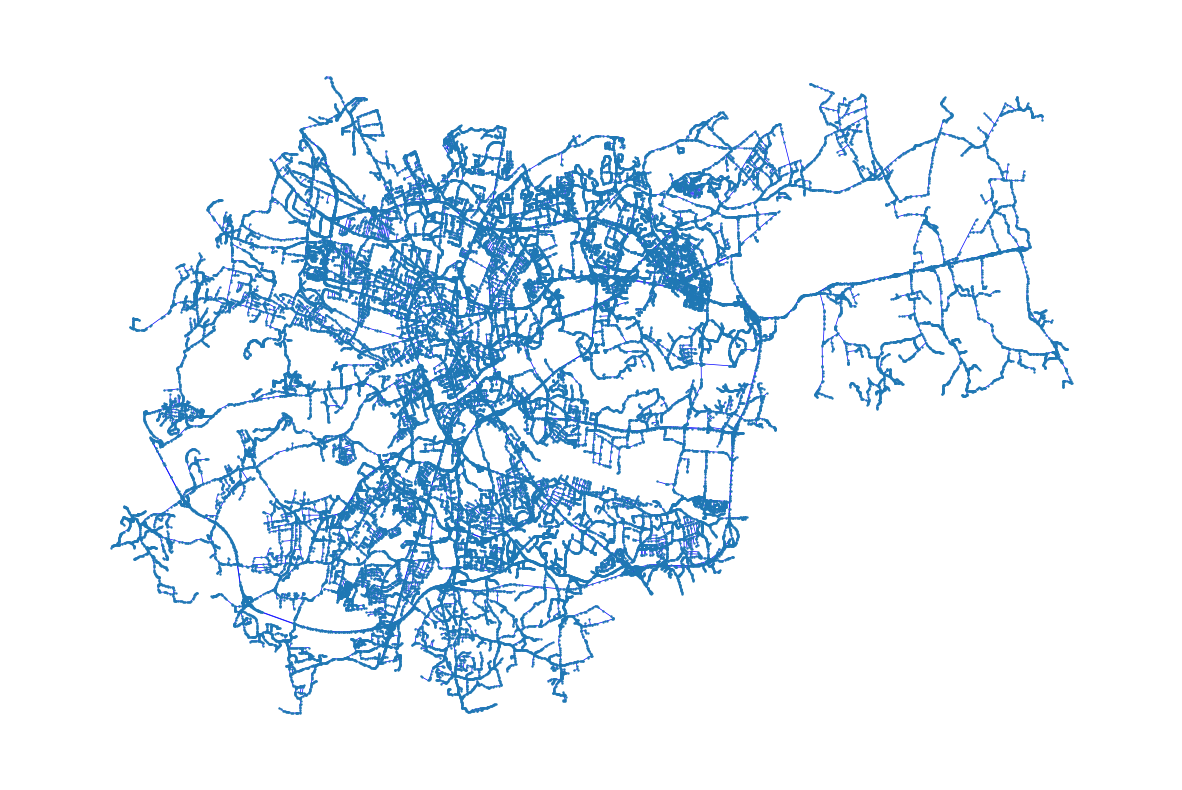

In [15]:
#plot graph
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0.5, edge_color='blue', width=0.5)


In [16]:
#choose 2 random points from nearest_gdf
sampled_points = nearest_gdf.sample(2, random_state=123)
display(sampled_points)


#calculate shortest path between 2 points in graph
distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
print('Distance in graph:', distance_in_graph, 'm')



#calculate distance in straight line between 2 points
from geopy.distance import geodesic
from shapely.geometry import Point

point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
print('Straight line distance:', straight_line_distance, 'm')


,id,distance,geometry
211,7086813203,10.584078,POINT (19.94544 50.04281)
54,3090689453,14.422227,POINT (19.89459 50.01771)


Distance in graph: 4590.189529581706 m
Straight line distance: 4590.197629566327 m


(19.75345804, 20.25184736, 49.955793164999996, 50.136551435)

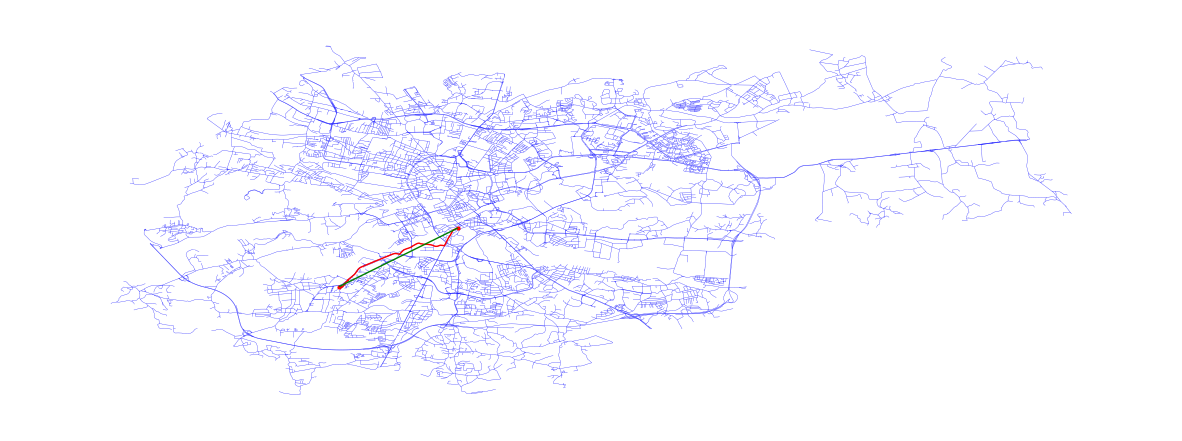

In [17]:
from shapely.geometry import LineString

#plot sampled points and shortest path between them
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(*point1.xy, color='red', marker='o', markersize=2)
plt.plot(*point2.xy, color='red', marker='o', markersize=2)
nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0, edge_color='blue', width=0.2)
shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
shortest_path_line = LineString(shortest_path)
shortest_path_gdf = gpd.GeoDataFrame(geometry=[shortest_path_line])
shortest_path_gdf.plot(ax=ax, color='red', linewidth=1)
straight_line = LineString([point1, point2])
straight_line_gdf = gpd.GeoDataFrame(geometry=[straight_line])
straight_line_gdf.plot(ax=ax, color='green', linewidth=1)

plt.axis('off')

Jak można zauważyć wartość odległości w grafie jest niedoszacowana, dlatego obliczymy ją takim samym sposobem jak wcześniej dla wszystkich krawędzi grafu

In [18]:
#pętla przez wszystkie krawędzie grafu i obliczenie odległości między punktami na nowo
for u, v, data in tqdm.tqdm(G.edges(data=True)):
    point1 = Point(u)
    point2 = Point(v)
    distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    data['weight'] = distance


100%|██████████| 83714/83714 [00:07<00:00, 10894.53it/s]


In [19]:
#choose 2 random points from nearest_gdf
sampled_points = nearest_gdf.sample(2, random_state=123)
display(sampled_points)

#calculate shortest distance between 2 points in graph
distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
print('Distance in graph:', distance_in_graph, 'm')

#calculate distance in straight line between 2 points
from geopy.distance import geodesic
from shapely.geometry import Point

point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
print('Straight line distance:', straight_line_distance, 'm')


,id,distance,geometry
211,7086813203,10.584078,POINT (19.94544 50.04281)
54,3090689453,14.422227,POINT (19.89459 50.01771)


Distance in graph: 5350.001895157851 m
Straight line distance: 4590.197629566327 m


In [20]:
def dwie_żaby (id1, id2):
    sampled_points = nearest_gdf[nearest_gdf['id'].isin([id1, id2])]
    point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
    point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
    straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    print('Distance in graph:', distance_in_graph, 'm')
    print('Straight line distance:', straight_line_distance, 'm')
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.plot(*point1.xy, color='red', marker='o', markersize=2)
    plt.plot(*point2.xy, color='red', marker='o', markersize=2)
    nx.draw(G, pos={node: node for node in G.nodes()}, ax=ax, node_size=0, edge_color='blue', width=0.2)
    shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    shortest_path_line = LineString(shortest_path)
    shortest_path_gdf = gpd.GeoDataFrame(geometry=[shortest_path_line])
    shortest_path_gdf.plot(ax=ax, color='red', linewidth=1)
    straight_line = LineString([point1, point2])
    straight_line_gdf = gpd.GeoDataFrame(geometry=[straight_line])
    straight_line_gdf.plot(ax=ax, color='green', linewidth=1)
    plt.axis('off')
    return distance_in_graph, straight_line_distance

def dwie_żaby_html (id1, id2):
    sampled_points = nearest_gdf[nearest_gdf['id'].isin([id1, id2])]
    point1 = Point(sampled_points.iloc[0]['geometry'].x, sampled_points.iloc[0]['geometry'].y)
    point2 = Point(sampled_points.iloc[1]['geometry'].x, sampled_points.iloc[1]['geometry'].y)
    straight_line_distance = geodesic((point1.y, point1.x), (point2.y, point2.x)).m
    distance_in_graph = nx.shortest_path_length(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    print('Distance in graph:', distance_in_graph, 'm')
    print('Straight line distance:', straight_line_distance, 'm')
    import folium
    m = folium.Map(location=[50.06465, 19.94498], zoom_start=13)
    folium.Marker([point1.y, point1.x], popup='Start').add_to(m)
    folium.Marker([point2.y, point2.x], popup='End').add_to(m)
    folium.PolyLine([(point1.y, point1.x), (point2.y, point2.x)], color='green').add_to(m)
    shortest_path = nx.shortest_path(G, source=tuple(sampled_points.iloc[0]['geometry'].coords[0]), target=tuple(sampled_points.iloc[1]['geometry'].coords[0]), weight='weight')
    for i in range(len(shortest_path) - 1):
        folium.PolyLine([(shortest_path[i][1], shortest_path[i][0]), (shortest_path[i + 1][1], shortest_path[i + 1][0])], color='red').add_to(m)
    #add exact points of Żabka to plot
    zaba1 = zabki_gdf[zabki_gdf['id'] == id1]
    zaba2 = zabki_gdf[zabki_gdf['id'] == id2]
    folium.Marker([zaba1.iloc[0]['geometry'].y, zaba1.iloc[0]['geometry'].x], popup='Żabka 1 <br> ID: ' + str(id1) + '<br> Graph distance: ' + str(round(distance_in_graph,2)) + 'm <br> Straight line distance: ' + str(round(straight_line_distance,2)) + 'm').add_to(m)
    folium.Marker([zaba2.iloc[0]['geometry'].y, zaba2.iloc[0]['geometry'].x], popup='Żabka 2 <br> ID: ' + str(id2) + '<br> Graph distance: ' + str(round(distance_in_graph,2)) + 'm <br> Straight line distance: ' + str(round(straight_line_distance,2)) + 'm').add_to(m)

    import webbrowser
    m.save('map.html')
    webbrowser.open('map.html')
    return distance_in_graph, straight_line_distance



Tutaj można ręcznie wpisać id 2 żabek korzystając z wcześniejszej mapy i otworzy się mapa z trasą i odległością w linii prostej.

In [21]:
#draw 2 random żabka ids
import random
id1 = zabki_gdf['id'].sample(1).values[0]
id2 = zabki_gdf['id'].sample(1).values[0]
print(id1, id2)
dwie_żaby_html(id1, id2)

10059113916 5115865714
Distance in graph: 2743.507005217066 m
Straight line distance: 2120.1235813675307 m


(2743.507005217066, 2120.1235813675307)

# Tworzenie macierzy ścieżek i odległości

In [29]:
#create matrix of shortest paths between all points
path_matrix = np.zeros((neares_gdf.shape[0], neares_gdf.shape[0]), dtype='object')
#try load matrix from file
try:
    path_matrix = np.load('path_matrix.npy', allow_pickle=True)
except:
    pass

def reverse_path(path):
    return path[::-1]

for i in tqdm.tqdm(range(neares_gdf.shape[0])):
    for j in range(neares_gdf.shape[0]):
        if i == j:
            path_matrix[i, j] = 0
        if i >= j:
            continue
        if path_matrix[i, j] != 0:
            continue # path already calculated
        
        path_matrix[i, j] = nx.shortest_path(G, source=tuple(neares_gdf.iloc[i]['geometry'].coords[0]), target=tuple(neares_gdf.iloc[j]['geometry'].coords[0]), weight='weight')
        path_matrix[j, i] = reverse_path(path_matrix[i, j])
    if i % 10 == 0:
        np.save('path_matrix.npy', path_matrix)
np.save('path_matrix.npy', path_matrix)



 43%|████▎     | 161/372 [00:25<00:33,  6.24it/s]


KeyboardInterrupt: 

In [ ]:
path_matrix_df = pd.DataFrame(path_matrix, index=neares_gdf['id'], columns=neares_gdf['id'])
path_matrix_df.head()